# Lane Detection Pipeline

By: Akshay Aggarwal
aksagg88@gmail.com

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries.

---
## Adding relavant modules
In this section I have added the relavant modules and also defined some global variables, a logger to help debig the code

In [55]:
# coding: utf-8

# IMPORT relevant modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import glob
import os
import logging
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#imageio.plugins.ffmpeg.download()


PREV_LEFT_SLOPE = 0
PREV_RIGHT_SLOPE = 0
PREV_LEFT_POINTS = [0,0,0]
PREV_RIGHT_POINTS = [0,0,0]

def reset_vars():
    global PREV_LEFT_SLOPE 
    global PREV_RIGHT_SLOPE 
    global PREV_LEFT_POINTS 
    global PREV_RIGHT_POINTS 
    
    PREV_LEFT_SLOPE = 0
    PREV_RIGHT_SLOPE = 0
    PREV_LEFT_POINTS = [0,0,0]
    PREV_RIGHT_POINTS = [0,0,0]
    
logging.basicConfig(level=logging.INFO)
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.disabled = True

---
## Camera Calibration

This section defines the methods used to calculate the instrinsic calibration paramters such as the camera matrix and the distortion coffecients using the camera calibarion images of a chessboard. Additional Methods are also defined to "un-distort" an image using the claculated camera calibration. A test method is provided to test the camera calibration on a test image

1. define the pattern size. Calibration images used in this program have the following pattern parameters
 * pattern_x = 10 
 * pattern_y = 7
 * square_size = 1
2. for every calibration image, use findchessboardcorners(), add to the image points
3. USe calibratecamera() to to get camera matrix and distortion coefficeints

usage: 

camera_matrix,dist_coefs = camera_cal(folder,file,pattern_x,pattern_y,square_size)



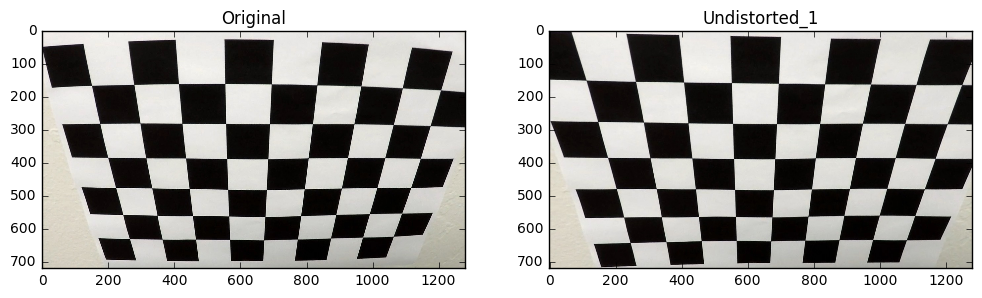

In [56]:
def camera_cal(folder,file,pattern_x,pattern_y,square_size):

    pattern_size = (pattern_x -1, pattern_y - 1) 
    pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    pattern_points *= square_size

    obj_points = []
    img_points = []
    h, w = 0, 0
    img_names_undistort = []
    
    # create image list
    images = glob.glob('./'+folder+'/'+file+'*'+'.jpg')
    out_path = glob.glob('./'+folder+'/')
    out = False
    
    for fn in images:
        logger.info('processing %s... ' % fn)
        img = cv2.imread(fn)
        if img is None:
            logger.info("Failed to load", fn)
            continue
        h, w = img.shape[:2]
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size)
        if ret:
            term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
            cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
            img_points.append(corners)
            obj_points.append(pattern_points)

        if out:
            cv2.drawChessboardCorners(vis, pattern_size, corners, found)
            outfile = glog.glob(out_path+file+'_chess.png')
            cv2.imwrite(outfile, vis)
            if found:
                img_names_undistort.append(outfile)
        if not ret:
            logger.info('chessboard not found')
            continue

    logger.info('ok')

    # calculate camera distortion
    rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

    logger.debug("\nRMS:", rms)
    logger.debug("camera matrix:\n", camera_matrix)
    logger.debug("matrix: \n", type(camera_matrix))
    logger.debug("distortion coefficients: ", dist_coefs.ravel())
    
    return(camera_matrix,dist_coefs)
    
def undistort_1(image, camera_matrix, dist_coefs):
    """
    undustort the image using camera_matrix and distortion coefficeint parameters
    """
    undst = cv2.undistort(image,camera_matrix,dist_coefs)
    return(undst)

def undistort_2(image,camera_matrix, dist_coefs):
    """
    undistort the image of a differnet size using camera_matrix and distortion coefficeint parameters
    """
    h,w =image.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
    undst = cv2.undistort(image, camera_matrix, dist_coefs, None, newcameramtx)
    x, y, w, h = roi
    undst = undst[y:y+h, x:x+w]
    return(undst)

def test_camera_cal():
    # Function to test calibration
    camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)
    distorted_image = mpimg.imread("./camera_cal/calibration2.jpg")
    corrected1 = undistort_1(distorted_image, camera_matrix, dist_coefs)

    f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
    ax1.imshow(distorted_image)
    ax1.set_title('Original', fontsize=12)
    ax2.imshow(corrected1)
    ax2.set_title('Undistorted_1', fontsize=12)

    plt.show()
    
test_camera_cal()

---
## Birds Eye View

The birds eye view is used to correct the perspective projection in the images due to the pose of the camera. The src is a array of points on the image and the dst is the array of corresponding points withtout the perspective. 

The warper method is used to :
1. Compute and apply perspective transform from SRC to DST points
2. Also, to un-warp the image by switching src and dst inputs



In [57]:
def warper(image, src, dst):
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

---
## Edge Feature Extraction

This methid extracts the lane edges from a given image. The following steps used to do this:
1. Grayscale conversion
2. Apply CLAHE filter to improve contrast and refine edge boundaries
3. Gausian blur to reduce detail 
4. Added a sobel x filter to reduce horizontal noise
4. Call Canny edge detection
5. If not enough edges, dialate to make them continuous
6. If too many edges impose higher canny threshold


In [58]:
def pre_process_canny(image, debug = False):

    # PARAMETERS
    imshape = image.shape
    kernel_size = 7
    sigma_x = 5
    sigma_y = 30
    low_canny_threshold = 25
    high_canny_threshold = low_canny_threshold * 3
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray2 = clahe.apply(gray)
    smooth = cv2.GaussianBlur(gray2, (kernel_size, kernel_size), sigma_x, sigma_y)
    
    sobelx64f = cv2.Sobel(smooth,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)
    
    canny_edges = cv2.Canny(sobel_8u, low_canny_threshold, high_canny_threshold)
    
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(canny_edges, kernel, iterations=1) 
    num_edge_pixels = len(np.nonzero(canny_edges)[0])
    logger.debug('number of edge pixels',num_edge_pixels)
    if  num_edge_pixels> 30000:
        edges = cv2.Canny(smooth, 75, 180, apertureSize=3)
        
    if debug == True:
        f, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, figsize=(12, 18))
        ax1.imshow(gray, cmap = 'Greys_r')
        ax1.set_title('grayscale', fontsize = 12)
        ax2.imshow(gray2, cmap = 'Greys_r')
        ax2.set_title('CLAHE', fontsize = 12)
        ax3.imshow(smooth, cmap = 'Greys_r')
        ax3.set_title('Gausian Blur', fontsize=12)
        ax4.imshow(edges, cmap = 'Greys_r')
        ax4.set_title('Edges', fontsize=12)    
    
    plt.show()
    
    return edges

def test_pre_process_canny(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/Lane-Detection/test_images/test1.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    edges = pre_process_canny(img, True)

--- 
## Color Feature Extraction
This is used to extract the lane edges based on the color information. The following steps are used to acheive this:

1. Convert BGR to HSV
2. Threshold the HSV image to get only yellow colors
3. Threshold the RBG image to get only white colors
4. Or the thresholded images to create a mask
5. Bitwise-AND mask and original image
6. Erode to reduce selected pixels

In [59]:
def colorfilter(frame): 
    """
   
    """
    
    image = np.copy(frame)
    param_1 = 68
    param_2 = 60
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsl = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)

    yellow_1 = cv2.inRange(hsv, np.array([90, 50, 50]), np.array([100, 255, 255]))
    yellow_2 = cv2.inRange(hsv, np.array([20, 100, 100]), np.array([50, 255, 255]))
    white_1 = cv2.inRange(image, np.array([200,200,200]), np.array([255,255,255]))
    white_2 = cv2.inRange(hsv, np.array([0,0,255-param_1]), np.array([255,20,255]))
    white_3 = cv2.inRange(hsl, np.array([0,255-param_2,0]), np.array([255,255,param_2]))
    
    mask = yellow_1 | yellow_2 |white_1 |white_2 |white_3
    
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    kernel = np.ones((5,5), np.uint8)
    img = cv2.erode(res, kernel, iterations=2)
    
    return(img[:,:,0])

def test_colorfilter(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/Lane-Detection/test_images/test3.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    result = colorfilter(img)
    plt.imshow(result, cmap = 'Greys_r')
    plt.show()    

---
## Region of Interest Mask
 Applies an image mask.
Only keeps the region of the image defined by the polygon
formed from `vertices`. The rest of the image is set to black.
1. vertice set 1, vertices set 1 for the birds eye view
2. defining a blank mask to start with
3. defining a 3 channel or 1 channel color to fill the mask with depending on the input image
4. filling pixels inside the polygon defined by vertices with the fill color    
5. returning the image only where mask pixels are nonzero

In [60]:
def roi_mask(image):
    imshape = image.shape
    '''
    vertices set 1
    y_max = imshape[0]-70
    y_min = 11*imshape[0]/18
    x_min = 0
    x_1 = 9*imshape[1]/20
    x_2 = 11*imshape[1]/20
    x_max = imshape[1]
    '''
    
    #vertices set 2
    y_max = imshape[0]-70
    y_min = imshape[0]/10
    x_min = 0 + 80
    x_1 = 5*imshape[1]/20
    x_2 = 15*imshape[1]/20
    x_max = imshape[1] - 80

    vertices = np.array([[(x_min,y_max), (x_1, y_min), (x_2, y_min),(x_max,y_max)]], dtype=np.int32)
    mask = np.zeros_like(image)   

    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, [vertices], ignore_mask_color)

    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def test_roi_mask():
    test_img_path = '/Users/enterprise/Dev/Git/Lane-Detection/test_images/test3.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    result = roi_mask(img)
    plt.imshow(result)
    plt.show()
    
    

---
## Feature Detection

The edge and color features extracted in the previous steps are used in this step. Lines present in the given image are detected through the probablistic Hough Transform. The detected line segments are classified as  part of left lane or right lane based on a set of heuristic conditions. 

for each set of classified line segments, a representative line is created using the average slope and X intercept. 

Finally, the weighted average method is used to create a first order filter and tom ensure that the detected lines dont move abrupbtuly from one frame to the other. 


In [61]:
def line_detect(roi_frm):
    ret = 1
    h,w = roi_frm.shape   # height and width in pixels

    rho = 1             # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 150      # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    line_image = np.zeros((h,w,3), np.uint8)
    #line_image = np.copy(roi_frm)*0 # creating a blank to draw lines on

    # Run Probabilistic Hough Transform to extract line segments from Binary image.
    lines = cv2.HoughLinesP(roi_frm,rho,theta,hough_threshold,min_line_length,max_line_gap)

    
    #Variable decleration
    y_max = h-20
    y_min = 0

    global PREV_LEFT_SLOPE, PREV_RIGHT_SLOPE, PREV_LEFT_POINTS, PREV_RIGHT_POINTS
    prev_weight = 0.9

    r_Y_arr = []
    r_X_arr = []
    r_Slope_arr = []
    r_intercept = []

    l_Y_arr = []
    l_X_arr = []
    l_Slope_arr = []
    l_intercept = []


    logger.info(' processing ...')
    # Loop for every single line detected by Hough Transform
    
    #exception in no lines are found
    if lines is None: 
        r_Slope_arr.append(PREV_RIGHT_SLOPE)
        r_X_arr.append(PREV_RIGHT_POINTS[0])
        r_X_arr.append(PREV_RIGHT_POINTS[2])
        r_Y_arr.append(PREV_RIGHT_POINTS[1])
        r_Y_arr.append(y_max)
        r_intercept.append(PREV_RIGHT_POINTS[2])
        
        l_Slope_arr.append(PREV_LEFT_SLOPE)
        l_X_arr.append(PREV_LEFT_POINTS[0])
        l_X_arr.append(PREV_LEFT_POINTS[2])
        l_Y_arr.append(PREV_LEFT_POINTS[1])
        l_Y_arr.append(y_max)
        l_intercept.append(PREV_LEFT_POINTS[2])
        
    else:
        logger.info('%d lines detect ...' % lines.shape[0])
        for line in lines:
            for x1,y1,x2,y2 in line:
                dx = x2 - x1 + 0.001
                dy = y2 - y1
                #slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
                slope = dy / dx
                theta = np.abs(np.arctan2((y2-y1), (x2-x1)))
                angle = theta * (180/np.pi)
                if abs(angle)>20:         #for removing horizontal lines
                    # Right lane marking -> positive slope and in right half of the frame
                    if x1 > 0.4*w and x2 > 0.4*w and angle > 80:
                        r_Y_arr.extend([y1,y2])
                        r_X_arr.extend([x1,x2])
                        #r_XY_arr = np.append(r_XY_arr,[[x1,x2],[y1,y2]],1)
                        r_Slope_arr.append(slope)
                        if angle>89.9:
                            x_int = x1
                        else:
                            x_int =  int(x1 + (-y_max + y1) / - slope)
                        r_intercept.append(x_int)
                        logger.debug('right',x1,y1,x2,y2,slope,angle,x_int) 
                        #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
                    # left lane marking -> negative slope and in left half of the frame
                    elif x1 < 0.6*w and x2 < 0.6*w and angle > 80:
                        l_Y_arr.extend([y1,y2])
                        l_X_arr.extend([x1,x2])
                        #l_XY_arr = np.append(l_XY_arr,[[x1,x2],[y1,y2]],1)
                        l_Slope_arr.append(slope)
                        if angle>89.9:
                            x_int = x1
                        else:
                            x_int =  int(x1 + (-y_max + y1) / - slope)
                        l_intercept.append(x_int)
                        logger.debug('left',x1,y1,x2,y2,slope,angle,x_int)
                        #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)

    data_lanes = np.array((l_Slope_arr,r_Slope_arr,l_Y_arr,l_X_arr,r_Y_arr,r_X_arr))

    # Right Lane
    if r_Y_arr:
        r_x2 = np.average(r_intercept)
        r_slope = np.average(r_Slope_arr)
        
        # Update slope 
        if PREV_RIGHT_SLOPE !=0:
            r_slope = r_slope + (PREV_RIGHT_SLOPE - r_slope) * prev_weight

        logger.debug('R_slope=',r_slope)
        logger.debug('r_x2=',r_x2)
        
        r_x2 = int(r_x2)
        r_y2 = y_max
        r_y1 = y_min
        r_x1 = int(r_x2 + (-r_y2 + r_y1)/ r_slope)
    
        # Update rest of the cordinates
        if PREV_RIGHT_SLOPE !=0:
            r_x1 = int(r_x1 + (PREV_RIGHT_POINTS[0] - r_x1) * prev_weight)
            r_y1 = int(r_y1 + (PREV_RIGHT_POINTS[1] - r_y1) * prev_weight)
            r_x2 = int(r_x2 + (PREV_RIGHT_POINTS[2] - r_x2) * prev_weight)

        PREV_RIGHT_SLOPE = r_slope
        PREV_RIGHT_POINTS = [r_x1, r_y1, r_x2]
        logger.info('Right',r_x1, r_y1, r_x2, y_max,r_slope)
        cv2.line(line_image, (r_x1, r_y1), (r_x2, r_y2), (255,0,0), 20)
    else:
        logger.debug('No Right Lane!!!')
        ret = 0


    # Left Lane
    if l_Y_arr:
        l_x2 = np.average(l_intercept)
        l_slope = np.average(l_Slope_arr)
        
        if PREV_LEFT_SLOPE !=0:
            l_slope = l_slope + (PREV_LEFT_SLOPE - l_slope) * prev_weight

        l_x2 = int(l_x2)
        l_y2 = y_max
        l_y1 = y_min
        l_x1 = int(l_x2 + (-l_y2 + l_y1) /l_slope)
        
        logger.debug('l_slope=',l_slope)
        logger.debug('l_x2=',l_x2)

        if PREV_LEFT_SLOPE !=0:
            l_x1 = int(l_x1 + (PREV_LEFT_POINTS[0] - l_x1) * prev_weight)
            l_y1 = int(l_y1 + (PREV_LEFT_POINTS[1] - l_y1) * prev_weight)
            l_x2 = int(l_x2 + (PREV_LEFT_POINTS[2] - l_x2) * prev_weight)

        PREV_LEFT_SLOPE = l_slope
        PREV_LEFT_POINTS = [l_x1, l_y1, l_x2]
        logger.info('Left' ,l_x1, l_y1, l_x2, y_max,l_slope)
        cv2.line(line_image, (l_x1, l_y1), (l_x2, l_y2), (255,0,0), 20)
    else:
        logger.debug('No Left Lane !!!')
        ret = 0
    
    return(ret,line_image)
    

---
## Processing Pipeline

The pipeline method recieves the image and the imtrinsic camera parameters and provides annotated image with lane markers identified. This pipeline can be used to process images or frames from a video. The following steps are impemented in this method:
1. Recieve image
2. Correct distortion based on received camera matrix and distortion coefficeint
3. Inverse perspective mapping to correct the perspective projection
4. Edge and color based feature extraction
5. Line detection and lane marking
6. Transform the line markings from a birds eye view to perspective projection
7. Combine line markings to the recieved image 

**pipeline**(image,camera_matrix, dist_coefs,test_im = True,debug = False):
 - image : Input image
 - camera_matrix: Camera matrix
 - dist_coefs: Distortion coefficients
 - test_im = True: For video input, set to False to apply moving average lane tracking
 - debug = False: Set to True to disply various stages of the pipeline 

In [62]:
def pipeline(image,camera_matrix, dist_coefs,test_im = True,debug = False):
    logger.info('Pipeline initiated ...')
    if test_im:
        reset_vars()
    
    frame = np.copy(image)
    img_size = frame.shape

    corrected_img = undistort_1(frame, camera_matrix, dist_coefs)
    logger.info('Distortion corrected')
    
    src =  np.float32([[0.203125*img_size[1],0.94444442*img_size[0]],
                       [0.81640625*img_size[1],0.94444442*img_size[0]],
                       [0.421875*img_size[1],0.68055558*img_size[0]],
                       [0.5859375*img_size[1],0.68055558*img_size[0]]])
    
    
    dst =  np.float32([[0.234375*img_size[1],0.97222221*img_size[0]],
                       [0.859375*img_size[1],0.97222221*img_size[0]],
                       [0.234375*img_size[1],0.06944445*img_size[0]],
                       [0.859375*img_size[1],0.06944445*img_size[0]]])
    

    top_view = warper(corrected_img,src,dst)
    canny_edges = pre_process_canny(top_view)
    logger.info('Canny edges',canny_edges.shape)
    lane_pixels = colorfilter(top_view)
    logger.info('Thresholding edges',lane_pixels.shape)
    ret, line_image = line_detect(canny_edges+lane_pixels)
    #print(line_image.shape, line_image.dtype)
    
    combo = cv2.addWeighted(line_image, 0.9, top_view, 1, 0)
    dist_view_1 = warper(line_image,dst,src)
    #combo_2 = cv2.addWeighted(dist_view_1, 0.95, corrected_img, 1, 0)
    combo_2 = cv2.add(corrected_img,dist_view_1)
    logger.info('... Pipeline complete!')
    
    if debug:
        print('output at different states of the pipeline')
        f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, figsize=(12, 18))
        ax1.imshow(frame)
        ax1.set_title('original image', fontsize = 12)
        ax2.imshow(top_view)
        ax2.set_title('IPM', fontsize=12)
        ax3.imshow(canny_edges, cmap = 'Greys_r')
        ax3.set_title('Canny Edges', fontsize=12)
        ax4.imshow(lane_pixels, cmap = 'Greys_r')
        ax4.set_title('Color Edges', fontsize=12)
        ax5.imshow(line_image, cmap = 'Greys_r')
        ax5.set_title('Hough line', fontsize=12)
        ax6.imshow(combo_2)
        ax6.set_title('Hough line unwarped', fontsize=12)

        plt.show()
    
    return(combo_2)
    

In [63]:
# In[237]:
def test_pipeline():
    test_img_path = '/Users/enterprise/Dev/Git/Lane-Detection/test_images/test3.jpg'
    camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)

    img = mpimg.imread(test_img_path)
    logger.info('Processing... '+test_img_path)
    if img is None:
        logger.debug("Failed to load", fn)

    result = pipeline(img,camera_matrix, dist_coefs,True, True)
    logger.info('OK')
    

---
## Test Methods
### Testing the given image set

**test_images**(test_images_path, save = False, plot = True):
 - test_image_path: Directory path containing the images
 - output_image_path: Directory path to save the output images
 - save: Boolean. True to save output images to the specified outptu directory
 - plot: Boolean. True to plot the results


In [64]:
# Test Images
def test_images(test_images_path,output_image_path, save = False, plot = True):
    camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)
    
    
    # create image list    
    for ind, fn in enumerate(test_images_path):
        print('processing %s... ' % fn, end='')
        img = mpimg.imread(fn)
        if img is None:
            print("Failed to load", fn)
            continue
        result = pipeline(img,camera_matrix, dist_coefs,True,False)
        print('ok',ind)
        if save:
            #plt.imshow(result)
            infile = os.path.basename(fn)
            outfile = (output_image_path+infile+'_output.png')
            cv2.imwrite(outfile,result)
        
    
        if plot:
            fig, ((axs1, axs2)) = plt.subplots(1,2, figsize=(12, 18), facecolor='w', edgecolor='k')
            axs1.imshow(img)
            axs1.set_title('Input:'+fn, fontsize = 12)
            axs2.imshow(result)
            axs2.set_title('Output:'+outfile, fontsize = 12)
            plt.show()
        
        result = None
    return

### Testing the given image set

**test_videos**(video_file, output_video_path):
 - video_file: Video file path
 - output_video_path: Output path for the video
 
 Information regarding Codecs and video extension courtesy: [http://www.pyimagesearch.com/2016/02/22/writing-to-video-with-opencv/]


In [65]:
def test_videos(video_file, output_video_path):

    camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)    
    cap = cv2.VideoCapture(video_file)
    print("Processing... "+video_file,end='')
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(7)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = None
    (h,w) = (None, None)
    zeros = None
    
    infile = os.path.basename(video_file)
    outfile = (output_video_path+infile+'_output.avi')
    cnt = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            cnt+= 1
            if writer is None:
                (h,w) = frame.shape[:2]
                writer = cv2.VideoWriter(outfile,fourcc, fps, (w,h),True)
                
            result = pipeline(frame,camera_matrix, dist_coefs,test_im = False)
            writer.write(result)
        else:
            break
    print('ok')
    # Release everything if job is finished
    cap.release()
    writer.release()
    return()

output at different states of the pipeline


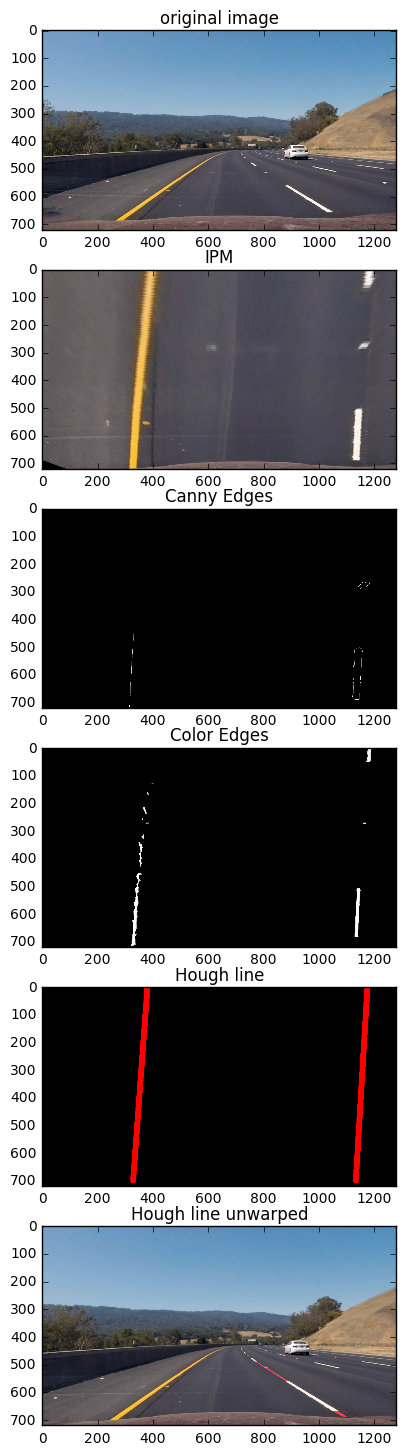

processing test_images/test1.jpg... ok 0


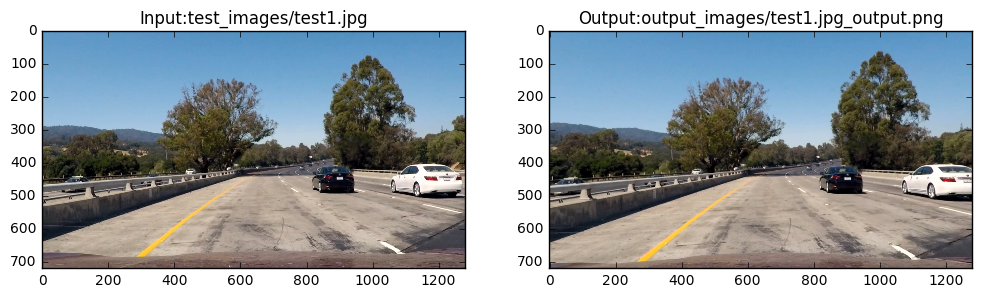

processing test_images/test2.jpg... ok 1


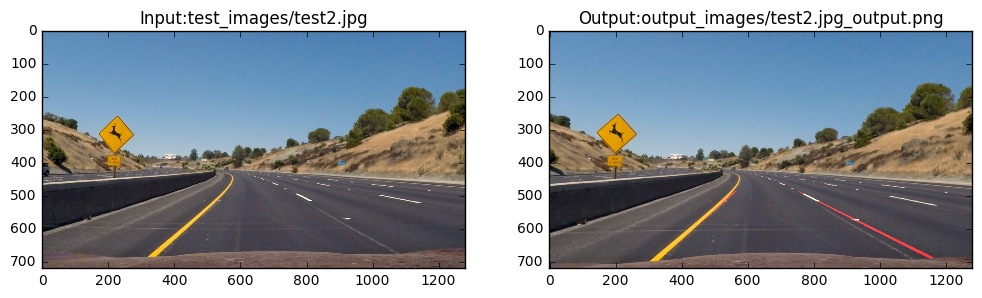

processing test_images/test3.jpg... ok 2


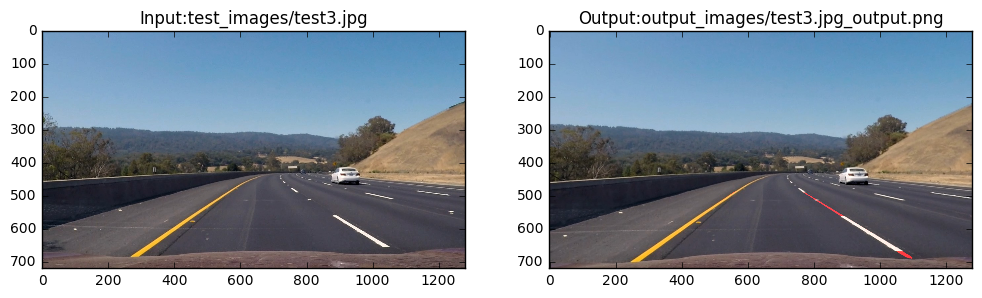

processing test_images/test4.jpg... ok 3


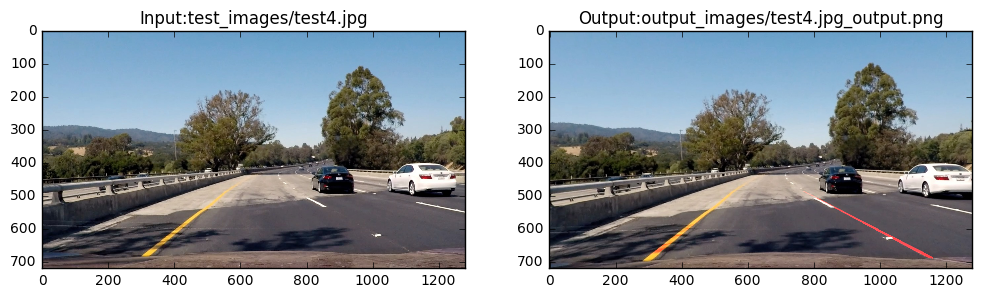

processing test_images/test5.jpg... ok 4


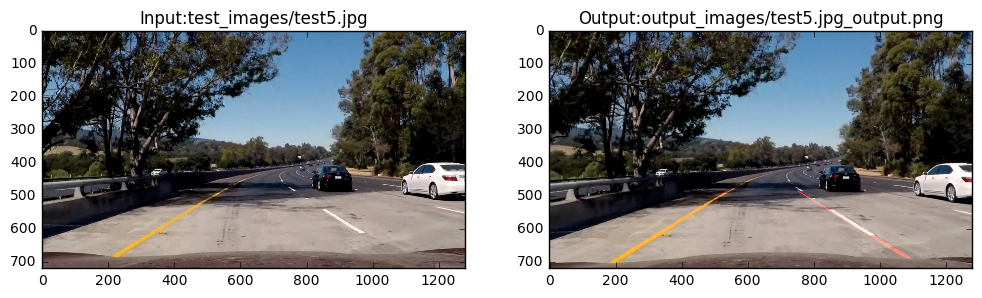

processing test_images/test6.jpg... ok 5


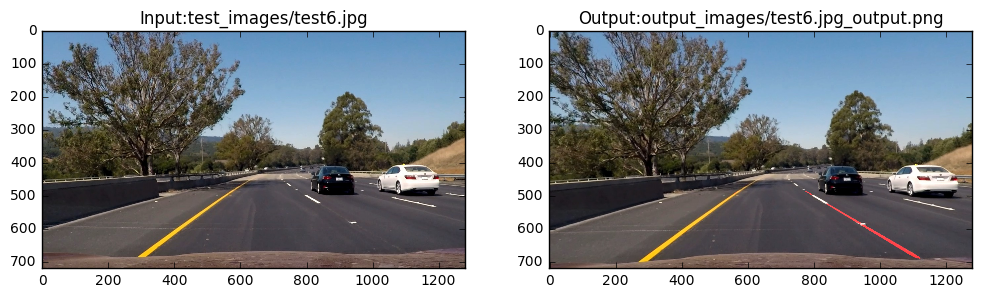

Processing... ./test_videos/project_video.mp4ok


In [70]:
def main():
    
    cal_images_path = 'camera_cal'
    test_images_path = glob.glob('test_images/test*.jpg')
    test_videos_path = glob.glob('./test_videos/*.mp4')
    output_image_path = 'output_images/'
    output_video_path = '/Users/enterprise/Desktop/resources/output_videos/'
    #output_video_path = 'output_videos/'
    
    #test_camera_cal()
    #test_pre_process_canny(test_img_path)
    #test_colorfilter(test_img_path)
    #test_roi_mask()
    
    test_pipeline()
    test_images(test_images_path,output_image_path,True,True)
    test_videos(test_videos_path[2],output_video_path)
    
    
if __name__ == "__main__":
    main()


## Summary and Reflection

Git-Repository :[https://github.com/aksagg88/Advanced-Lane-Detection.git]

This report demonstrates the implementation of a basic lane detection algorithm using a combination of the edge and color based feature extraction and Hough line detection. Though the concept of the algorithm was relatively simple, the actual was a lot harder than I my expectation. After implementing this lane detection pipeline, I have a greater appreciation of the challenges in deploying a vision based in real world setting.

The feature extraction method used in this algorithm leaves a lot more to be desired. Specially in driving situations with shadow cover and faded lanes the algorithm is unable to detect lanes. using a first order filter improves the performance a little bit but a better detection and tracking method is required